# DYNAMIC HAND GESTURE RECOGNITION USING 3D CONVNETS

**Authors: Niladri Das, Roopshali Roy, Soumodeep Kundu**<br> 
*Last edit made: 29.03.2024*

This notebook is used to train the model used in our paper titled 'Controlling Desktop with Hand-Gestures using 3D Convolutional Networks'. 

The model defined in this notebook is inspired by the paper [Real-Time Monocular Skeleton-Based Hand Gesture Recognition Using 3D-Jointsformer' by Enmin Zhong et al.](https://www.mdpi.com/1424-8220/23/16/7066)

This notebook was created so as to train a model from scratch (Creating datasets, dataloaders, etc.) and hence it is recommended to execute each cell in the order they are present.

The dataset used to train the model is the [Multi-Modal Hand Gesture Dataset for Hand Gesture Recognition](https://www.gti.ssr.upm.es/data/MultiModalHandGesture_dataset). It contains 17 different hand gestures. The Kaggle dataset,
created by Roopshali, can be found [here](https://www.kaggle.com/datasets/roopshaliroy21/multimodhandgestrecog). It is recommended to add the given dataset to the notebook before starting the execution. 


In [5]:
# Install necessary dependencies
!pip install graphviz
!pip install torchview

In [6]:
# Standard Library Imports
import os
import gc
import math

# External Library Imports
import cv2
import torch
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# PyTorch Specific Imports
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torchvision import transforms
from torchview import draw_graph

# Data Processing and Visualization Imports
from PIL import Image
import matplotlib.pyplot as plt
import random
import pickle

# For docs
from typing import Any

# UTILITY FUNCTIONS

#### The functions defined below are used to make the job of loading and saving stuff easier. 
#### They are referenced multiple times throughout the notebook so be sure to execute them!

In [7]:
def check_or_create_dir(path: str) -> None:
  """
  Creates a directory if it does not already exist.

  Args:
      path (str): The path to the directory to create.

  Returns:
      None
  """

  if not os.path.exists(path):
    os.makedirs(path)
    print("Dir created successfully!")
  else:
    print("Dir is already present!")

In [8]:
def load_pkl_obj(path: str) -> Any:
  """
  Loads a pickled object from a file.

  Args:
      path (str): The path to the pickle file containing the object.

  Returns:
      Any: The loaded object.
  """

  with open(path, 'rb') as fp:
    data = pickle.load(fp)
  print("Object was loaded successfully!")
  return data

In [9]:
def save_pkl_obj(path: str, obj: Any) -> None:
  """
  Saves an object to a pickle file.

  Args:
      path (str): The path to save the pickle file.
      obj (Any): The object to be pickled and saved.

  Returns:
      None
  """

  with open(path, 'wb') as fp:
    pickle.dump(obj, fp)
  print("Object was saved successfully!")

# READING LABELS

Get the labels of the distinct classes and store them in ``labels``.
Also create another dict ``class_dict`` to store the reverse mapping 

In [10]:
# Set Root dir
ROOT_DIR = '/kaggle/input/MultiModHandGestRecog/near-infrared'

# NOTE: If it throws something like 'File/Dir cannot be found' etc., just copy the root dir of your dataset and paste it here.

In [ ]:
def getlabels(root_dir: str) -> dict:
    
    """
  Extracts labels from a directory structure with nested folders for users and actions.

  Args:
      root_dir (str): The root directory containing the labeled data.
          It's expected to have a structure like:
          root_dir/user_XX/test_gesture/C/00/...
          root_dir/user_XX/test_pose/down/...
          root_dir/user_XX/train_pose/L/...
          (where "C", "down", "L", etc. are the action labels)

  Returns:
      dict: A dictionary containing unique action labels as keys and their assigned integer IDs as values.
      - Example: {"C": 0, "down": 1, "L": 2, ...}
    """
    
    labels = {} 
    l0 = os.listdir(root_dir)
        
    #iterate over [user_01, user_02,...]
    for fol1 in l0:
        #print("lo-",fol1)
        p1 = os.path.join(root_dir, fol1)
        l1 = os.listdir(p1)
            
        #iterate over [test_gesture, test_pose, train_pose]
        for fol2 in l1:
            #print("l1-",fol2)
            p2 = os.path.join(p1, fol2)
            l2 = os.listdir(p2)
                
            #iterate over [C, L, down....]
            for act in l2:
                #print("l2-",act)
                if act not in labels:
                    size = len(labels)
                    labels[act] = size

    return labels

getlabels(ROOT_DIR)

In [ ]:
#for reverse mapping
labels = getlabels(ROOT_DIR)
idx_dict = {idx:label for label,idx in labels.items()}
idx_dict

# STACKING IMAGES

#### We're training a 3D ConvNet. Meaning we need 3D inputs (spatial dimensions of width + height + a temporal dimension).
#### In order to acheive that we stack frames captured from a video at regular intervals in order to create a single input Tensor.

In [12]:
def stack_images(image_dir: str, min_frames: int = 8, dims: tuple[int,int] = (224,224), channels: int = 3) -> torch.Tensor:
  """
  Loads and stacks images from a directory into a 4D PyTorch tensor suitable for deep learning models.

  Args:
      image_dir (str): Path to the directory containing the images.
      min_frames (int, optional): Minimum number of frames to stack. Defaults to 8.
      dims (tuple[int, int], optional): Desired output image dimensions (height, width). Defaults to (224, 224).
      channels (int, optional): Number of color channels (1 for grayscale, 3 for RGB). Defaults to 3.

  Returns:
      torch.Tensor: A 4D PyTorch tensor representing the stacked image sequence with dimensions
                    (channels, min_frames, height, width).

  Raises:
      ValueError: If no images are found in the directory or min_frames is less than 1.
  """
  
  image_paths = []
  image_tensors = []
  channel_type = 'L' if channels == 1 else 'RGB'
  
  # Define resizing and normalization transformations (adjust as needed)
  resize_transform = transforms.Resize(dims)
  to_tensor_transform = transforms.ToTensor()
  normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
  image_transform = transforms.Compose([resize_transform, to_tensor_transform, normalize_transform])
  
  # Get image paths from the directory
  for filename in os.listdir(image_dir):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
      image_path = os.path.join(image_dir, filename)
      image_paths.append(image_path)
  
  # Load and transform only up to max_frames images
  for i, image_path in enumerate(image_paths):
    if i >= min_frames:
      break  # Stop processing after reaching max_frames
    image = Image.open(image_path).convert(channel_type)
    image = image_transform(image)
    image_tensors.append(image)

  # Augment data if no. of frames < min_frames
  if len(image_tensors) < min_frames:
    rem = min_frames - len(image_tensors)
    idx = len(image_tensors) - 2
    sign = -1
    for i in range(rem):
        if idx == -1:
            idx = 1
            sign = 1
        if idx == len(image_tensors):
            idx = len(image_tensors) - 2
            sign = -1
            
        image_tensors.append(image_tensors[idx])
        idx += sign

  # Stack tensors into a 4D PyTorch tensor     
  stacked_images = torch.stack(image_tensors, dim=1)
  
  return stacked_images

### Let's make a tensor by stacking frames. Note the shape it returns:

In [30]:
# Example usage:
image_dir = ROOT_DIR + "/user_01/train_pose/ok"
stacked_image_tensor = stack_images(image_dir, 16, (112,112))
stacked_image_tensor.shape

torch.Size([3, 16, 112, 112])

In [13]:
def show_sample_image(stacked_image_tensor: torch.Tensor, label: int = None, class_dict: dict = None) -> None:
    """
  Visualizes a sequence of images represented by a 4D PyTorch tensor.

  Args:
      stacked_image_tensor (torch.Tensor): A 4D tensor representing the stacked image sequence
                                            (batch_size=1, channels, height, width).
      label (int, optional): The integer class label of the image sequence (if available). Defaults to None.
      class_dict (dict, optional): A dictionary mapping class labels to human-readable names (if available).
                                    Defaults to None.

  Returns:
      None
    """
    
    #get max frames
    no_of_frames = stacked_image_tensor.shape[1]
    rows = math.floor(no_of_frames / 2)
    columns = no_of_frames - rows
    
    # create figure 
    fig = plt.figure(figsize=(10, 12)) 
    fig.suptitle('This is a somewhat long figure title')
    if class_dict is None or label is None:
        fig.suptitle('Sample Image')
    else:
        fig.suptitle(f"Sample Image - class label: {class_dict[label]}")
    for i in range(no_of_frames):
        
        #select a frame
        image = stacked_image_tensor[:,i]
        image = image.numpy()
        
        # Move color channel to the last dimension if necessary (depending on transformation)
        image = image.transpose(1, 2, 0)
        fig.add_subplot(rows, columns, i+1) 
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Frame {i+1}")

### Let's see how the tensor we just made by stacking frames looks like:

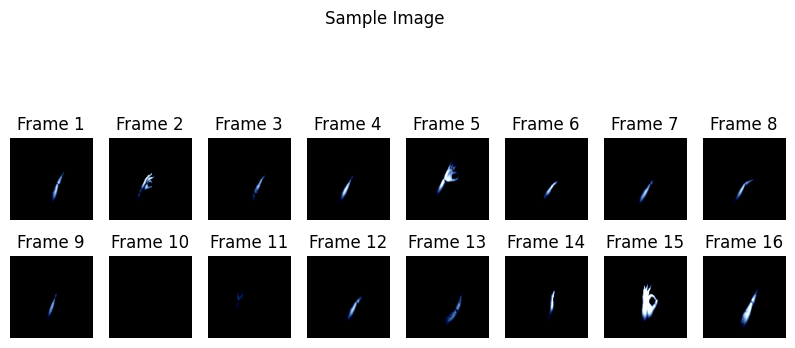

In [32]:
# Display frames
show_sample_image(stacked_image_tensor)

### We need to collect all the image directory paths in one place. The function defined below does that:

In [ ]:
def get_image_dir_paths(root_dir: str) -> list[str]:
        """
  Extracts image directory paths from a specific folder structure within a root directory.

  Args:
      root_dir (str): The root directory containing the data. The expected structure is:
          root_dir/user_XX/test_gesture/action_X/image_folders/...
          OR
          root_dir/user_XX/test_pose|train_pose/action_X/image_folders/...
          (where "user_XX" are user directories, "action_X" are action labels,
          and "image_folders" contain the actual image files)

  Returns:
      list[str]: A list of full paths to all image directories within the specified structure.
  """
        
        image_dir_paths = []
        l0 = os.listdir(root_dir)
        
        #iterate over [user_01, user_02,...]
        for fol1 in l0:
            #print("lo-",fol1)
            p1 = os.path.join(root_dir, fol1)
            l1 = os.listdir(p1)
            
            #iterate over [test_gesture, test_pose, train_pose]
            for fol2 in l1:
                #print("l1-",fol2)
                p2 = os.path.join(p1, fol2)
                l2 = os.listdir(p2)
                
                #iterate over [C, L, down....]
                for act in l2:
                    #print("l2-",act)
                    p3 = os.path.join(p2, act)                    
                    l3 = os.listdir(p3)
                    
                    if fol2 == "test_gesture": 
                        for fol4 in l3: 
                            p4 = os.path.join(p3, fol4)
                            l4 = os.listdir(p4)
                            image_dir_paths.append(p4)
                    else:
                            image_dir_paths.append(p3)
                    
                
        return image_dir_paths

### `image_dir_paths` now contains the path to all of the image directories of the dataset. Note the length of the list. That is the total number of samples in the dataset

In [ ]:
image_dir_paths = get_image_dir_paths(ROOT_DIR)
len(f'Number of samples: {len(image_dir_paths)}')

# SAVE THE DATA

#### We do not want to execute the above cells again (in case we want to run this notebook in the future). It is better to save everything we've done so far.

In [14]:
# Define paths
data_dir_path = '/kaggle/working/data/'
image_dir_path = data_dir_path + 'image_dir_path_list'
labels_dict_path = data_dir_path + 'class_labels_dict'
idx_dict_path = data_dir_path + 'idx_dict'

In [ ]:
# Prepare the data directory
check_or_create_dir(data_dir_path)

# Save the path list
save_pkl_obj(image_dir_path, image_dir_paths)

# Save the labels dict
save_pkl_obj(labels_dict_path, labels)
    
# Save the idx dict
save_pkl_obj(idx_dict_path, idx_dict)

# LOAD THE SAVED DATA

#### This part should serve as the starting point in case we've already executed the above cells and decide to run the notebook again (other than the import cell). That being said, there is no harm in executing these cells even if we don't need to re-load the data.

In [15]:
# Load image_dir_path_list
image_dir_paths = load_pkl_obj(image_dir_path)

# Load idx_dict
idx_dict = load_pkl_obj(idx_dict_path)

# Load labels dict
labels = load_pkl_obj(labels_dict_path)

Object was loaded successfully!
Object was loaded successfully!
Object was loaded successfully!


In [16]:
# perform sanity checks
print(f'Number of samples = {len(image_dir_paths)}')
for path in image_dir_paths[0:2]:
    print(path)
print(f'labels = {list(labels.keys())}')
print(f'index = {list(idx_dict.keys())}')

Number of samples = 3022
/kaggle/input/MultiModHandGestRecog/near-infrared/user_10/train_pose/two
/kaggle/input/MultiModHandGestRecog/near-infrared/user_10/train_pose/four
labels = ['two', 'four', 'five', 'fist_moved', 'ok', 'palm_m', 'three', 'down', 'C', 'hang', 'index', 'up', 'palm', 'L', 'heavy', 'palm_u', 'right', 'left']
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


# CUSTOM PYTORCH DATASET

#### Creating a custom PyTorch dataset class that will serves as our dataset from now on. Will call ``stack_images`` to stack images and form a tensor.

In [17]:
#Dataset class
class MMHGD(Dataset):
    """
  A PyTorch Dataset class for loading and preprocessing images from a multi-modal hierarchical gesture dataset.

  Attributes:
      image_dir_paths (list[str]): A list of paths to directories containing image sequences.
      labels_to_idx_dict (dict): A dictionary mapping action labels to their corresponding integer IDs.
      min_frames (int): The minimum number of frames to stack for each sample.
      dims (tuple[int, int]): Desired output dimensions for the stacked image tensors (height, width).
      channels (int): Number of color channels (1 for grayscale, 3 for RGB).
    """
    
    def __init__(self, image_dir_paths: list, labels_to_idx_dict: dict, min_frames: int, dims: tuple[int,int], channels: int):
        self.labels_to_idx_dict = labels_to_idx_dict
        self.min_frames = min_frames
        self.dims = dims
        self.channels = channels
        self.image_dir_paths = image_dir_paths
        
    
    def __len__(self):
        return len(self.image_dir_paths)
        
        
    def __getitem__(self, idx):
        img_dir_path = self.image_dir_paths[idx]
        split_path = img_dir_path.split('/')
        if len(split_path) > 8:
            label = self.labels_to_idx_dict[split_path[-2]]
        else: 
            label = self.labels_to_idx_dict[split_path[-1]]
        stacked_image_tensor = stack_images(img_dir_path, self.min_frames, self.dims, self.channels)
        return stacked_image_tensor, label

#### We now define the dimensions of our data (width, height, no. of frames, channels, etc.)

In [18]:
# Set params for data
DIMS = (224,224)
MIN_FRAMES = 16
CHANNELS = 3
LABELS_TO_IDX_DICT = labels
BATCH_SIZE = 8

# Initialize data config 
data_config = {
    'dims': DIMS,
    'min_frames': MIN_FRAMES,
    'channels': CHANNELS,
    'BATCH_SIZE': BATCH_SIZE
}

In [35]:
# Create an instance of the dataset
dataset = MMHGD(image_dir_paths, LABELS_TO_IDX_DICT, MIN_FRAMES, DIMS, CHANNELS)

#### Let's fetch a random sample from our newly created dataset.

Number of samples: 3022
Shape of a single input tensor: torch.Size([3, 16, 224, 224])


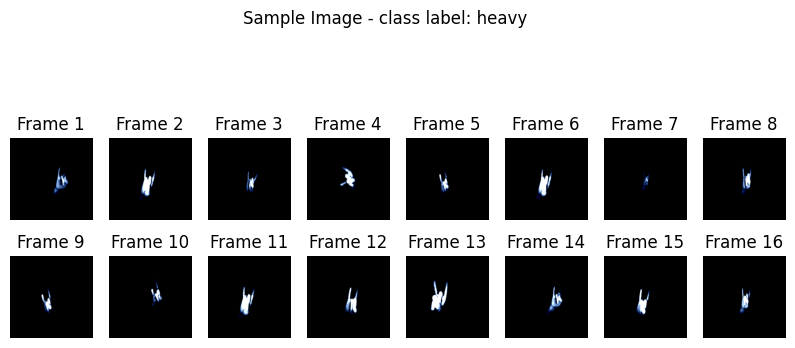

In [36]:
def check_dataset(dataset: MMHGD) -> None:
    """
  Analyzes and visualizes a sample from the provided MMHGD dataset.

  Args:
      dataset (MMHGD): An instance of the MMHGD Dataset class.

  Returns:
      None
   """
    
    #Get number of samples in dataset
    print(f"Number of samples: {len(dataset)}")

    # Get a random image index
    random_idx = random.randint(1, len(dataset))
    image, label = dataset[random_idx]
    print(f"Shape of a single input tensor: {image.shape}")
    
    # Show a random sample
    show_sample_image(image, label, idx_dict)

check_dataset(dataset)

# CREATING DATALOADERS

#### PyTorch Dataloaders are, as their name implies, used for loading data in batches while training or testing the model. Here we create them.

In [37]:
def create_dataloaders(dataset: MMHGD, batch_size: int = 2) -> tuple[DataLoader, DataLoader, DataLoader]:
  """
  Splits a given MMHGD dataset into training, validation, and testing subsets and creates PyTorch dataloaders for each.

  Args:
      dataset (MMHGD): An instance of the MMHGD Dataset class.
      batch_size (int, optional): The batch size for the dataloaders. Defaults to 2.

  Returns:
      tuple[DataLoader, DataLoader, DataLoader]: A tuple containing three dataloaders:
          - train_dataloader: DataLoader for the training set (shuffled).
          - val_dataloader: DataLoader for the validation set (not shuffled).
          - test_dataloader: DataLoader for the testing set (not shuffled).
  """

  total_len = len(dataset)
  train_ratio = 0.8
  val_ratio = 0.1
  test_ratio = 0.1

  # Calculate sizes based on ratios
  train_size = int(train_ratio * total_len)
  val_size = int(val_ratio * total_len)
  test_size = total_len - train_size - val_size

  # Split the dataset using random_split
  train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
      dataset, lengths=[train_size, val_size, test_size])

  # Create dataloaders with shuffle for training and no shuffle for validation/test
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_dataloader, val_dataloader, test_dataloader

In [ ]:
# Example usage
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(dataset, BATCH_SIZE)

In [38]:
def check_batches(train_dataloader: DataLoader, val_dataloader: DataLoader, 
                  test_dataloader: DataLoader) -> torch.Tensor:
    """
  Analyzes the dataloaders to get information about batch sizes, shapes, and number of batches.

  Args:
      train_dataloader (DataLoader): PyTorch DataLoader instance for the training set.
      val_dataloader (DataLoader): PyTorch DataLoader instance for the validation set.
      test_dataloader (DataLoader): PyTorch DataLoader instance for the testing set.

  Returns:
      sample_batch (torch.Tensor): PyTorch tensor representing a single batch
    """
    
    train_batch, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_batch.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    print(f"No. of train batches: {len(train_dataloader)}")
    print(f"No. of val batches: {len(val_dataloader)}")
    print(f"No. of test batches: {len(test_dataloader)}")
    return train_batch

Feature batch shape: torch.Size([8, 3, 16, 224, 224])
Labels batch shape: torch.Size([8])
No. of train batches: 303
No. of val batches: 38
No. of test batches: 38


#### Let's see how our batches look like:

In [ ]:
# Check batch size, samples, etc.
sample_batch = check_batches(train_dataloader, val_dataloader, test_dataloader)

# SAVING THE DATALOADERS

#### Saving the dataloaders will preserve the samples in the training and test dataloaders in case we want to re-train or test our model in the future. Otherwise we'll have to create new dataloaders to train or test our model, which will give us inaccurate results, since the model was trained using a different dataloader.

In [39]:
# Initialize save paths
train_dataloader_path = data_dir_path + 'train_dataloader.pth'
test_dataloader_path = data_dir_path + 'test_dataloader.pth'
val_dataloader_path = data_dir_path + 'val_dataloader.pth'

In [40]:
# Save dataloaders
torch.save(train_dataloader, train_dataloader_path)
torch.save(test_dataloader, test_dataloader_path)
torch.save(val_dataloader, val_dataloader_path)

# THE MODEL

#### As mentioned before, the model below is an implementation of the model proposed by [Enmin Zhong et al.](https://www.mdpi.com/1424-8220/23/16/7066) in their paper - minus the Transformer encoder and the skeleton embeddings. It is actually a modified version of a 3D ResNet-18 model. Here, we code it from scratch. (credits to Soumodeep Kundu). For more details regarding the model architecture, refer to [this](https://paperswithcode.com/lib/torchvision/resnet-3d) article. 

In [19]:
class GestNet(nn.Module):
    """
    GestNet 3D Convolutional Neural Network Architecture for Gesture Recognition

This class defines a 3D CNN architecture called GestNet for recognizing gestures from video sequences.

Attributes:
in_ch (int): Number of input channels (e.g., 3 for RGB videos).
num_classes (int): Number of gesture classes to be recognized.

    """
    def __init__(self, in_ch: int, num_classes: int):
        super(GestNet, self).__init__()
        self.first_layer = nn.Sequential(
            nn.Conv3d(in_ch, 32, (1, 3, 3), (1, 3, 3)),
            nn.BatchNorm3d(32),
            nn.ReLU()
        )
        
        self.stack_2_1 = nn.Sequential(
            nn.Conv3d(32, 32, (1, 1, 1), stride=(1, 2, 2)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 128, (1, 1, 1)),
            nn.BatchNorm3d(128),
        )
        
        self.res_2_1 = nn.Sequential(
            nn.Conv3d(32, 128, (1, 1, 1), stride=(1, 2, 2)),
            nn.BatchNorm3d(128)                        
        )
        
        self.stack_2_2 = nn.Sequential(
            nn.Conv3d(128, 32, (1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 128, (1, 1, 1)),
            nn.BatchNorm3d(128),
        )
        
        self.stack_2_3 = nn.Sequential(
            nn.Conv3d(128, 32, (1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 128, (1, 1, 1)),
            nn.BatchNorm3d(128),
        )
        
        self.stack_2_4 = nn.Sequential(
            nn.Conv3d(128, 32, (1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 128, (1, 1, 1)),
            nn.BatchNorm3d(128)
        )
        
        self.stack_3_1 = nn.Sequential(
            nn.Conv3d(128, 64, (3, 1, 1), padding=(1, 0, 0), stride=(1, 2, 2)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 256, (1, 1, 1)),
            nn.BatchNorm3d(256),
        )
        
        self.res_3_1 = nn.Sequential(
            nn.Conv3d(128, 256, (1, 1, 1), stride=(1, 2, 2)),
            nn.BatchNorm3d(256)                        
        )
        
        self.stack_3_2 = nn.Sequential(
            nn.Conv3d(256, 64, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 256, (1, 1, 1)),
            nn.BatchNorm3d(256),
        )
        
        self.stack_3_3 = nn.Sequential(
            nn.Conv3d(256, 64, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 256, (1, 1, 1)),
            nn.BatchNorm3d(256),
        )
        
        self.stack_3_4 = nn.Sequential(
            nn.Conv3d(256, 64, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 256, (1, 1, 1)),
            nn.BatchNorm3d(256),
        )
        
        self.stack_3_5 = nn.Sequential(
            nn.Conv3d(256, 64, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 256, (1, 1, 1)),
            nn.BatchNorm3d(256),
        )
        
        self.stack_3_6 = nn.Sequential(
            nn.Conv3d(256, 64, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 256, (1, 1, 1)),
            nn.BatchNorm3d(256),
        )
        
        self.stack_4_1 = nn.Sequential(
            nn.Conv3d(256, 128, (3, 1, 1), padding=(1, 0, 0), stride=(1, 2, 2)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 128, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 512, (1, 1, 1)),
            nn.BatchNorm3d(512),
        )
        
        self.res_4_1 = nn.Sequential(
            nn.Conv3d(256, 512, (1, 1, 1), stride=(1, 2, 2)),
            nn.BatchNorm3d(512)                        
        )
        
        self.stack_4_2 = nn.Sequential(
            nn.Conv3d(512, 128, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 128, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 512, (1, 1, 1)),
            nn.BatchNorm3d(512),
        )
        
        self.stack_4_3 = nn.Sequential(
            nn.Conv3d(512, 128, (3, 1, 1), padding='same'),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 128, (1, 3, 3), padding='same'),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 512, (1, 1, 1)),
            nn.BatchNorm3d(512),
        )
        
        #Pooling + FC
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Sequential(
                    nn.Linear(512, 512),
                    nn.ReLU(),  
                    nn.Dropout(0.5)
                    )
        self.out = nn.Linear(512, num_classes)

        
        
    def forward(self, x):
        first_layer_out = self.first_layer(x)
        residual = first_layer_out

        second_stack_1 = self.stack_2_1(first_layer_out)
        residual = self.res_2_1(residual)
        second_stack_1 += residual
        second_stack_1 = F.relu(second_stack_1)
        residual = second_stack_1
        
        second_stack_2 = self.stack_2_2(second_stack_1)
        second_stack_2 += residual
        second_stack_2 = F.relu(second_stack_2)
        residual = second_stack_2
        
        second_stack_3 = self.stack_2_3(second_stack_2)
        second_stack_3 += residual
        second_stack_3 = F.relu(second_stack_3)
        residual = second_stack_3
        
        second_stack_4 = self.stack_2_4(second_stack_3)
        second_stack_4 += residual
        second_stack_4 = F.relu(second_stack_4)
        residual = second_stack_4
        
        third_stack_1 = self.stack_3_1(second_stack_4)
        residual = self.res_3_1(residual)
        third_stack_1 += residual
        third_stack_1 = F.relu(third_stack_1)
        residual = third_stack_1
        
        third_stack_2 = self.stack_3_2(third_stack_1)
        third_stack_2 += residual
        third_stack_2 = F.relu(third_stack_2)
        residual = third_stack_2
        
        third_stack_3 = self.stack_3_3(third_stack_2)
        third_stack_3 += residual
        third_stack_3 = F.relu(third_stack_3)
        residual = third_stack_3
        
        third_stack_4 = self.stack_3_4(third_stack_3)
        third_stack_4 += residual
        third_stack_4 = F.relu(third_stack_4)
        residual = third_stack_4
        
        third_stack_5 = self.stack_3_5(third_stack_4)
        third_stack_5 += residual
        third_stack_5 = F.relu(third_stack_5)
        residual = third_stack_5
        
        third_stack_6 = self.stack_3_6(third_stack_5)
        third_stack_6 += residual
        third_stack_6 = F.relu(third_stack_6)
        residual = third_stack_6
        
        fourth_stack_1 = self.stack_4_1(third_stack_6)
        residual = self.res_4_1(residual)
        fourth_stack_1 += residual
        fourth_stack_1 = F.relu(fourth_stack_1)
        residual = fourth_stack_1
        
        fourth_stack_2 = self.stack_4_2(fourth_stack_1)
        fourth_stack_2 += residual
        fourth_stack_2 = F.relu(fourth_stack_2)
        residual = fourth_stack_2
        
        fourth_stack_3 = self.stack_4_3(fourth_stack_2)
        fourth_stack_3 += residual
        fourth_stack_3 = F.relu(fourth_stack_3)
        out = fourth_stack_3
        
        pooled_features = self.avgpool(out)
        flattened_features = torch.flatten(pooled_features, start_dim=1)
        fc = self.fc(flattened_features)
        out = self.out(fc)
        
        return out

#### The directory defined below will store everything related to our model - its weights, hyperparams, and of course, the model itself.

In [22]:
# Initialize dir for storing models and model representations
model_dir = '/kaggle/working/models/'

In [43]:
# Create dir if not already present
check_or_create_dir(model_dir)

Dir is already present!


#### The code below generates a graphical representation of our model, for better understanding. 

In [ ]:
# Draw model graph
model = GestNet(CHANNELS, 18)
model_graph = draw_graph(model, 
                         input_size=(1, CHANNELS, MIN_FRAMES, DIMS[0], DIMS[1]),
                         graph_name = 'GestNet',
                         save_graph = True,
                         directory = model_dir,
                         device='meta',
                        )
model_graph.visual_graph

#### Let's test our model using a single batch from our dataloader

In [45]:
# Testing with a batch from our dataloader
model = GestNet(CHANNELS, 18)
out = model(sample_batch)
out.size()

torch.Size([8, 18])

# TRAINING

#### This section deals with training our model. We choose CCE Loss as our loss function becuase we're dealing with a multi class classification problem. The optimizer used is AdamW which helps with regularization to prevent overfitiing. We also use a learning rate scheduler to prevent our learning getting flatlined. 

#### The original model was trained using a NVIDIA T4 (The T4 GPU on Kaggle) on 60 epochs . Total training time was around 4 hours.

In [20]:
# Set device and free up memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()

In [47]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer,
                model_save_path,
                device,
                data_config,
                num_epochs=10
               ):
  """
  Trains a PyTorch model with early stopping based on validation loss.

  Args:
      model (torch.nn.Module): The model to be trained.
      train_dataloader (torch.utils.data.DataLoader): The dataloader for the training data.
      val_dataloader (torch.utils.data.DataLoader): The dataloader for the validation data.
      criterion (torch.nn.Module): The loss function used for training.
      optimizer (torch.optim.Optimizer): The optimizer used for training.
      model_save_path (str): The filename to save the best model state.
      device (str): The device to train the model on ("cpu" or "cuda").
      data_config (dict): Configuration dictionary containing data related parameters.
      num_epochs (int, optional): The number of epochs to train the model for. Defaults to 10.

  Returns:
      tuple: A tuple containing the trained model, training losses, and validation losses.
  """

  model.to(device)
  model.train()
  
  # Create scheduler for learning rate reduction
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
    
  train_losses, val_losses = [], []
  best_vloss = float('inf') 
  for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in train_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation step (model in eval mode for potential layer changes)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).item() * inputs.size(0)
    model.train()  # Switch back to train mode before next epoch

    epoch_val_loss = val_loss / len(val_dataloader.dataset)
    val_losses.append(epoch_val_loss)
    
    #save the model with the lowest val loss
    if epoch_val_loss < best_vloss:
        best_vloss = epoch_val_loss
        checkpoint = {'model': GestNet(CHANNELS,18),
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()
                     }

        torch.save(checkpoint, model_save_path)
    
    # Update learning rate based on validation loss
    scheduler.step(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

  # Load the model having the best val loss
  checkpoint = torch.load(model_save_path)
  model = GestNet(CHANNELS,18)
  model.load_state_dict(checkpoint['state_dict'])
  
  return model, train_losses, val_losses

#### Here we give our model a name:

In [23]:
# Define training params
model = GestNet(CHANNELS,18)
model_name = f'GestNet_{DIMS[0]}x{DIMS[1]}_{MIN_FRAMES}fps_{CHANNELS}ch'
print(f'Model name = {model_name}')
model_save_path = model_dir + model_name

Model name = GestNet_224x224_16fps_3ch


#### Here we define our loss function, optimizer and other hyperparams:

In [50]:
# Deine optimizers, criterion and start training
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0025, eps=1e-5)

In [51]:
# Start training
trained_model, train_losses, val_losses = train_model(model, 
                                                      train_dataloader, 
                                                      val_dataloader, 
                                                      criterion, 
                                                      optimizer,
                                                      model_save_path,
                                                      device,
                                                      data_config,
                                                      num_epochs=60
                                                     )

Epoch [1/60], Train Loss: 2.7023, Val Loss: 2.8719
Epoch [2/60], Train Loss: 2.4556, Val Loss: 2.2035
Epoch [4/60], Train Loss: 2.2905, Val Loss: 2.0855
Epoch [5/60], Train Loss: 2.2217, Val Loss: 2.1766
Epoch [6/60], Train Loss: 2.2271, Val Loss: 2.0529
Epoch [7/60], Train Loss: 2.1868, Val Loss: 2.0407
Epoch [8/60], Train Loss: 2.1620, Val Loss: 1.9699
Epoch [9/60], Train Loss: 2.1304, Val Loss: 1.9490
Epoch [10/60], Train Loss: 2.1383, Val Loss: 1.8924
Epoch [11/60], Train Loss: 2.0279, Val Loss: 1.7501
Epoch [12/60], Train Loss: 1.9364, Val Loss: 1.6541
Epoch [13/60], Train Loss: 1.8877, Val Loss: 1.6772
Epoch [14/60], Train Loss: 1.7639, Val Loss: 1.6674
Epoch [15/60], Train Loss: 1.6635, Val Loss: 1.4289
Epoch [16/60], Train Loss: 1.5764, Val Loss: 1.2794
Epoch [17/60], Train Loss: 1.4508, Val Loss: 1.1005
Epoch [18/60], Train Loss: 1.3686, Val Loss: 1.1167
Epoch [19/60], Train Loss: 1.3109, Val Loss: 1.0092
Epoch [20/60], Train Loss: 1.2298, Val Loss: 7.4972
Epoch [21/60], Train

#### We want to save our hyperparams for future reference (in case we want to re-train our model with them again). We do that here:

In [99]:
# Save hyperparams for future reference
hyperparams_path = model_dir + 'hyperparams'
hyperparams = {
    'Dropout': 0.5,
    'Normalized': True,
    'LR': 0.0025,
    'eps':1e-5,
    'LRSchedulerFactor': 0.1,
    'LRSchedulerPatience': 10,
    'Epochs': 60
}
save_pkl_obj(hyperparams_path, hyperparams)

# Save data configs for future reference
data_config_path = data_dir_path + 'data_config'
save_pkl_obj(data_config_path, data_config)

Object was saved successfully!
Object was saved successfully!


# PERFORMANCE METRICS

#### Let's see how our model is performing on the dataset.

In [54]:
# Initialize directory for storing images, metrics, etc.
metrics_fol = '/kaggle/working/metrics_fol/'
conf_mat_path = metrics_fol + 'conf_matrix.png'   # path to confusion matrix image file
loss_curve_path = metrics_fol + 'loss_curves.png' # path to loss curves image file

In [55]:
# Create directory if not created
check_or_create_dir(metrics_fol)

Dir is already present!


#### Here we plot the learning curves:

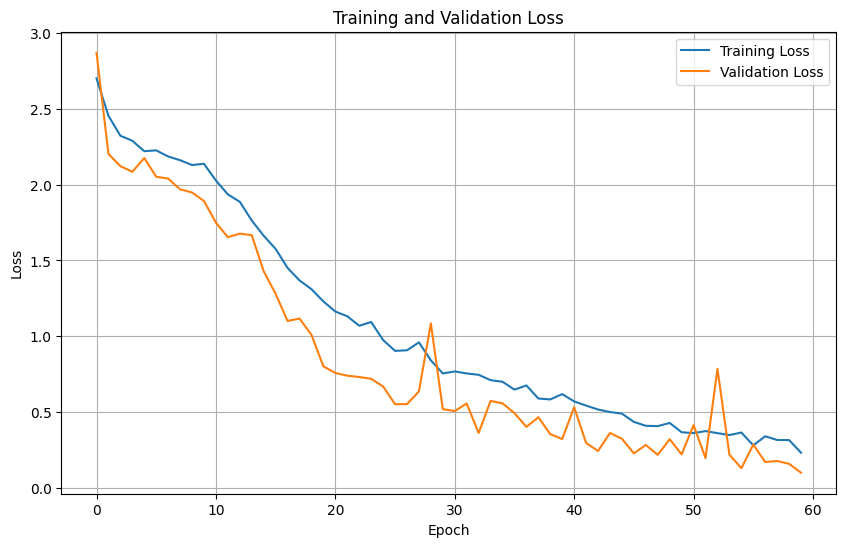

In [63]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

# Export the figure 
plt.savefig(loss_curve_path)

plt.show()


#### We use average accuracy, precision, recall and f1 scores to evaluate our model. We also generate a confusion matrix for each class to see how well the model can predict them.

In [ ]:
def get_metrics(model: nn.Module, test_dataloader: DataLoader, device: torch.device, criterion: nn.Module) -> dict:
    """
Evaluates a model on a given test dataloader and returns a dictionary containing various performance metrics.

Args:
model (nn.Module): The model to be evaluated.
test_dataloader (DataLoader): The dataloader containing the test data.
device (torch.device): The device (CPU or GPU) to use for computations.
criterion (nn.Module): The loss function used for evaluation.

Returns:
dict: A dictionary containing the following metrics:
- test_loss (float): Average loss across the test dataset.
- test_acc (float): Overall accuracy on the test dataset.
- precision (float): Weighted precision across all classes.
- recall (float): Weighted recall across all classes.
- f1_score (float): Weighted F1 score across all classes.
- conf_matrix (np.ndarray): Confusion matrix of predicted vs. actual labels.
    """
    
    # Set model to eval mode
    for parameter in model.parameters():
            parameter.requires_grad = False
    model.eval()
    
    model.to(device)

    # Initialize variables to track metrics
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Initialize arrays to hold predictions and targets
    all_predictions = []
    all_targets = []

    # Loop through the test dataloader
    with torch.no_grad():  # Disable gradient calculation for efficiency during evaluation
      for data, target in test_dataloader:
        data = data.to(device)
        target = target.to(device)  

        # Forward pass through the model
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)
        total_loss += loss.item()  # Sum losses across batches

        _, predicted = torch.max(output, dim=1) 
        
        # Add to data store
        all_predictions.extend(predicted.cpu())
        all_targets.extend(target.cpu())
        
        # Update metrics
        correct_predictions += (predicted == target).sum().item()
        total_samples += target.shape[0]

    # Calculate average loss and accuracy
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    # Compute weighted precision, recall, F-measure 
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average = 'weighted')    
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    
    # Compile results
    metrics = {
        'test_loss': average_loss,
        'test_acc': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'conf_matrix': conf_matrix
    }    
    return metrics

Test Loss: 0.0099
Test Accuracy: 0.9768
Precision: 0.9777
Recall: 0.9768
F1 score: 0.9767


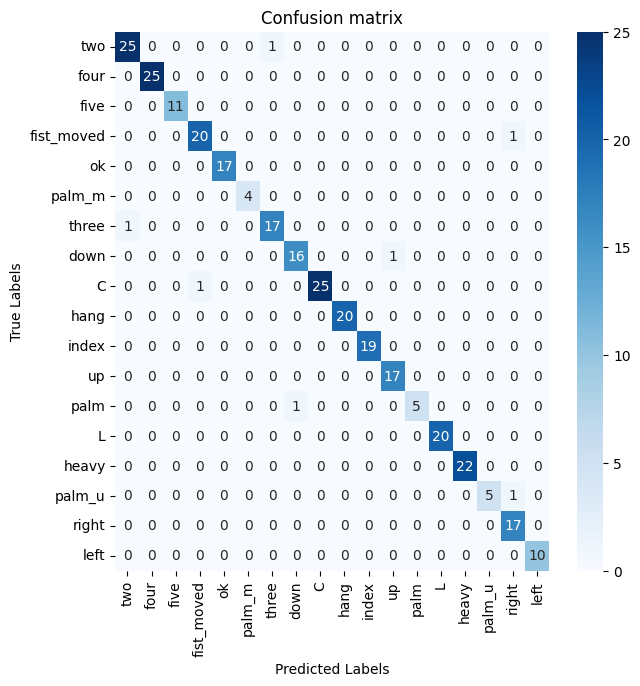

In [92]:
# Compute and display metrics
metrics = get_metrics(model, val_dataloader, device, criterion)

# Print metrics
print(f"Test Loss: {metrics['test_loss']:.4f}")
print(f"Test Accuracy: {metrics['test_acc']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 score: {metrics['f1_score']:.4f}")

# Generate confusion matrix
conf_matrix = metrics['conf_matrix']
# Encode labels
class_names = list(labels.keys())
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels = class_names,
            yticklabels = class_names
           )
plt.title('Confusion matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Export the figure 
plt.savefig(conf_mat_path)

# Show the matrix
plt.show()                    

#### Here we test our model by getting it to predict the class of a random sample in our dataset:

In [58]:
def get_prediction(model: nn.Module, device: torch.device) -> None:
    """
Gets a prediction for a randomly chosen image sequence from the provided dataset and prints the predicted class label.

Args:
model (nn.Module): The trained model to use for prediction.
device (torch.device): The device (CPU or GPU) to use for computations.

Returns: None
    """
    
    size = len(image_dir_paths)
    random_idx = random.randint(0,size-1)
    dir = image_dir_paths[random_idx]
    paths = dir.split('/')
    if len(paths) > 8:
        label = labels[paths[-2]]
    else:
        label = labels[paths[-1]]
    tensor = stack_images(dir, MIN_FRAMES, DIMS, CHANNELS)
    show_sample_image(tensor, label, idx_dict)

    model.to(device)
    out = model(tensor.to(device).unsqueeze(0))

    # Get the index of the class with the highest probability
    predicted_class_index = torch.argmax(out, dim=1)

    # Assuming you have a list of class labels (class_names) corresponding to the indices
    class_label = idx_dict[predicted_class_index.item()]
    print(f"Predicted Class Label: {class_label}")

Predicted Class Label: ok


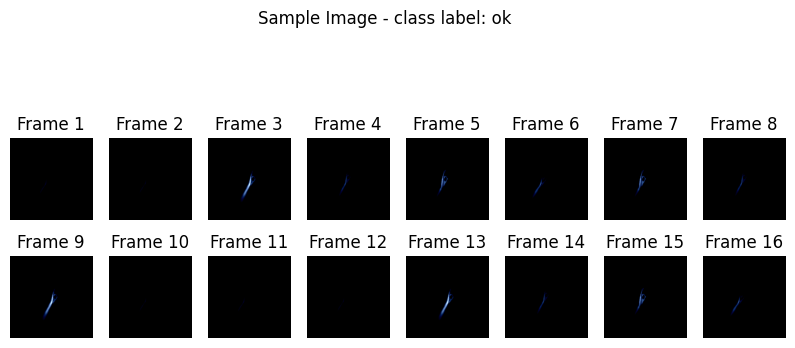

In [59]:
# Check the model's prediction against a random sample from the dataset
get_prediction(model, device)

# LOADING THE MODEL AND THE DATALOADERS

#### As again, this section should be executed if we want to load previously trained models/dataloaders for re-training or evaluation purposes. Still, no harm if we execute them anyway.

In [25]:
def load_checkpoint(filepath: str, device: torch.device) -> nn.Module:
    """
Loads a model checkpoint from a specified file and returns the model ready for inference.

Args:
    filepath (str): The path to the model checkpoint file.
    device (torch.device): The device (CPU or GPU) to load the model onto.

Returns:
    nn.Module: The loaded model, ready for inference.
    """
    checkpoint = torch.load(filepath, map_location=torch.device(device))
    model = GestNet(CHANNELS, 18)
    model.load_state_dict(checkpoint['state_dict'])  
    model.to(device)
    return model

In [ ]:
#Loading the model
model = load_checkpoint(model_save_path, device)

In [88]:
# Load dataloader
train_dataloader = torch.load(train_dataloader_path)
test_dataloader = torch.load(test_dataloader_path)
val_dataloader = torch.load(val_dataloader_path)

In [76]:
# check batches
_ = check_batches(train_dataloader, test_dataloader, val_dataloader)

Feature batch shape: torch.Size([8, 3, 16, 224, 224])
Labels batch shape: torch.Size([8])
No. of train batches: 303
No. of val batches: 38
No. of test batches: 38


# EXPORT TO ONNX FORMAT 

#### We've trained and saved our model. But for actually getting it to perform inference, it needs to be in a format that can be executed on any platform, in any environment. The `nn.Module` format in which our model is currently saved won't serve as that requires a Python environment plus all of the dependencies declared above. 

#### ONNX (Open Neural Network Exchange) solves this problem by serving as a runtime environment for our model. We can export our model in a .onnx format, and the ONNX runtime environment can then execute our model on any platform, in any language. You can read more about what ONNX is [here](https://onnxruntime.ai/)

In [ ]:
# Install ONNX runtime
!pip install onnx onnxruntime

In [44]:
# Import the onnx package
import torch.onnx

In [ ]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_checkpoint(model_save_path, device)
model.eval()

In [46]:
# Input to the model
x = torch.randn(BATCH_SIZE, CHANNELS, MIN_FRAMES, DIMS[0], DIMS[1], requires_grad=True)
torch_out = model(x)

In [47]:
# Set export path
onnx_model_path = model_dir + 'gest_net.onnx'

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  onnx_model_path,           # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

# LOAD THE ONNX MODEL AND PERFORM INFERENCE

In [32]:
import onnx

# Load the model
onnx_model = onnx.load(onnx_model_path)

# Check if it matches the model schema
onnx.checker.check_model(onnx_model)

In [ ]:
import onnxruntime

# start an ONNX runtime
ort_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

# utility fn to convert tensor->numpy ndarray
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}          # Input format is {input_name: input} 
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [57]:
# Perform inference with the ONNX model
path = '/kaggle/input/MultiModHandGestRecog/near-infrared/user_02/test_pose/three'
tensor = stack_images(path, MIN_FRAMES, DIMS, CHANNELS)

# Add an extra dim for batch
tensor = tensor.unsqueeze(0)  

# convert to numpy (ONNX models can only accept numpy inputs)
tensor = to_numpy(tensor)  

# Create input
ort_inputs = {ort_session.get_inputs()[0].name: tensor}

# Perform inference
ort_outs = ort_session.run(None, ort_inputs)
out = ort_outs[0]

# Get the class index with the max value
predicted_class_index = np.argmax(out)
class_label = idx_dict[predicted_class_index.item()]
print(f"Predicted Class Label: {class_label}")

Predicted Class Label: three
